# HATE SPEECH DETECTION - Sentiment Analysis Project


Viggiano Martina (954603)

## 1. Data import and error removal
Hate speech dataset from a white supremacist forum:  https://github.com/Vicomtech/hate-speech-dataset

In [1]:
import pandas as pd
import numpy as np
import glob
import os
from tqdm import tqdm
import ntpath
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
tqdm.pandas()

C:\Users\marti\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
all_files_paths = glob.glob("hate-speech-dataset/all_files/*.txt")

In [3]:
all_files_paths = [f for f in all_files_paths if os.path.isfile(f)]

In [4]:
all_files_names = [str(ntpath.basename(f)).replace(".txt", "") for f in all_files_paths]

In [5]:
txt_content = {}
errors = []
for name, path in tqdm(list(zip(all_files_names, all_files_paths))):
    with open(path, "r") as txt:
        try:
            txt_content[name] = txt.readline()
        except Exception as ex:
            errors.append((name, str(ex)))

100%|██████████| 10944/10944 [00:01<00:00, 6766.80it/s]


In [6]:
errors[:5]

[('13491591_4',
  "'charmap' codec can't decode byte 0x81 in position 23: character maps to <undefined>"),
 ('13493456_1',
  "'charmap' codec can't decode byte 0x81 in position 169: character maps to <undefined>"),
 ('13500400_1',
  "'charmap' codec can't decode byte 0x81 in position 67: character maps to <undefined>"),
 ('13560796_1',
  "'charmap' codec can't decode byte 0x81 in position 5: character maps to <undefined>"),
 ('13572081_1',
  "'charmap' codec can't decode byte 0x81 in position 3: character maps to <undefined>")]

In [7]:
errors_list = [err[0] for err in errors]

In [8]:
df = pd.DataFrame.from_dict(txt_content, orient='index').reset_index()
df.columns = ["file_id", "text"]

In [9]:
df.head()

,file_id,text
0,12834217_1,"As of March 13th , 2014 , the booklet had been..."
1,12834217_10,Thank you in advance. : ) Download the youtube...
2,12834217_2,In order to help increase the booklets downloa...
3,12834217_3,( Simply copy and paste the following text int...
4,12834217_4,Click below for a FREE download of a colorfull...


In [10]:
ann = pd.read_csv('hate-speech-dataset/annotations_metadata.csv')

In [11]:
ann.head()

,file_id,user_id,subforum_id,num_contexts,label
0,12834217_1,572066,1346,0,noHate
1,12834217_2,572066,1346,0,noHate
2,12834217_3,572066,1346,0,noHate
3,12834217_4,572066,1346,0,hate
4,12834217_5,572066,1346,0,noHate


In [12]:
ann = ann[~ann['file_id'].isin(errors_list)]

In [13]:
data = pd.merge(left=ann, right=df, left_on='file_id', right_on='file_id')
data.shape
data.head()

,file_id,user_id,subforum_id,num_contexts,label,text
0,12834217_1,572066,1346,0,noHate,"As of March 13th , 2014 , the booklet had been..."
1,12834217_2,572066,1346,0,noHate,In order to help increase the booklets downloa...
2,12834217_3,572066,1346,0,noHate,( Simply copy and paste the following text int...
3,12834217_4,572066,1346,0,hate,Click below for a FREE download of a colorfull...
4,12834217_5,572066,1346,0,noHate,Click on the `` DOWNLOAD ( 7.42 MB ) '' green ...


In [14]:
data['label'] = data.apply(lambda x: 0 if x['label'] == "noHate" else 1, axis=1)

### 2. Cleaning and tokenization

In [15]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import string
import nltk.sentiment.vader as vd
from nltk import download
download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

#### 2.1 Removing links, tags, numbers and bias

In [16]:
#engl = []
#other = []
#for x in range(len(data['text'])):
#    try:
#        if detect(data['text'][x]) == 'en':
#            engl.append(data['text'][x], detect(data['text'][x])
#        else:
#            other,(data['text'][x], detect(data['text'][x]))
#    except:
#        None

In [17]:
import re
cList = {
    "n't": "not",
    "/TD": " ",
    "pm": "personal message",
    "PM": "personal message",
    "Donot": "do not",
    "MB" : "megabytes"}
c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)

In [18]:
data['text']= [expandContractions(x) for x in data['text']]

In [19]:
additional  = ['rt','rts','retweet']
swords = set().union(stopwords.words('english'), additional, string.punctuation)
data['text_clean'] = data['text'].str.lower()\
    .str.replace('(@[a-z0-9]+)\w+',' ')\
    .str.replace(r'http\S+', '')\
    .str.replace(r'www\S+',' ')\
    .str.replace(r'com/watch', ' ')\
    .str.replace(r'\S*[.,:;!?-]\S*[^\s\.,:;!?-]',' ')\
    .str.replace(r' ca ', ' cannot ')\
    .str.replace(r'\w*\d\w*',' ')\
    .str.replace(r'rlm',' ')\
    .str.replace(r'pttm',' ')\
    .str.replace(r'ghlight',' ')\
    .str.replace('[0-9]+(?:st| st|nd| nd|rd| rd|th| th)', '')\
    .str.replace('([^a-z \t])',' ')\
    .str.replace(' +',' ')\
    .apply(lambda x: " ".join([i for i in x.split() if not i in swords]))
#any alpha numeric after @ #http # any value except alpha numeric tab character ('\u0009')
#.str.replace(r'#\S+', ' ')\

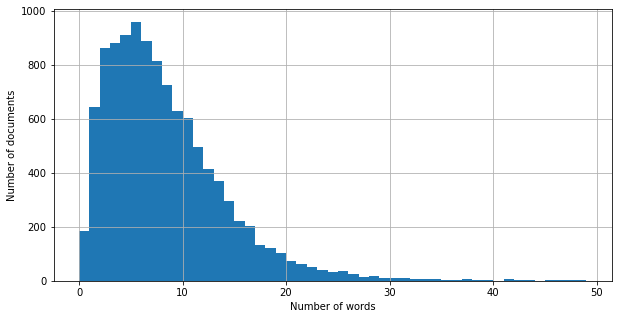

In [20]:
data['word_count'] = data['text_clean'].apply(lambda x: len(x.split())) # Number of words in the string
plt.figure(figsize=(10,5))
plt.hist(data.word_count.values, bins = range(0, 50))
plt.xlabel("Number of words")
plt.ylabel("Number of documents")
plt.grid(True)
plt.show()

In [21]:
data['text'][3156]

"Classic trucker songs YouTube - & #x202a ; Dave Dudley - Diesel Smoke ( 18WoS : PTTM ) & #x202c ; & rlm ; Diesel Smoke another of same song , different video , says the artist was Red Simpson YouTube - & #x202a ; Red Simpson - Diesel smoke , & #x202c ; & rlm ; YouTube - & #x202a ; Red Sovine-Truck Drivin ' Son Of A Gun & #x202c ; & rlm ; Truck Drivin ' Son of a Gun YouTube - & #x202a ; Terry Allen - Amarillo Highway & #x202c ; & rlm ; Amarillo Highway ( slow version , live , with violins ) YouTube - & #x202a ; Robert Earl Keen - Amarillo Highway & #x202c ; & rlm ; Fast rockin ' country version by Robert Earl Keene"

In [22]:
data['text_clean'][3156]

'classic trucker songs youtube dave dudley diesel smoke diesel smoke another song different video says artist red simpson youtube red simpson diesel smoke youtube red drivin son gun truck drivin son gun youtube terry allen amarillo highway amarillo highway slow version live violins youtube robert earl keen amarillo highway fast rockin country version robert earl keene'

In [23]:
data['text'][data['text_clean'].str.contains("#")]

Series([], Name: text, dtype: object)

In [24]:
# Stemming
ps = PorterStemmer()
data['stemmed'] = data['text_clean'].apply(lambda x: " ".join([ps.stem(i) for i in word_tokenize(x)]))

In [25]:
# Lemmatizer
lm = nltk.WordNetLemmatizer()
data['lemmatized'] = data['text_clean'].apply(lambda x: " ".join([lm.lemmatize(i) for i in word_tokenize(x)]))

In [26]:
data['tokens'] = data['lemmatized'].apply(word_tokenize)

In [27]:
from langdetect import detect
languages = []
for x in tqdm(range(len(data['text']))):
    try:
        languages.append(detect(data['text'][x]))
    except:
        None

100%|██████████| 10926/10926 [01:28<00:00, 123.76it/s]


In [28]:
other = []
for x in range(len(data['lemmatized'])):
    try:
        if detect(data['lemmatized'][x]) != 'en':
            print(data['lemmatized'][x], detect(data['lemmatized'][x]))
    except:
        None

booklet updated feb da
downloads pl
came across piece garbage ro
comment say sa tl
old tarzan movie zulu king kong many image tl
girl start talking guy middle lip start moving no
believe dog would like get far away possible af
watch hollywood movie en
v watch min obama aipac youtube en
v entire myron fagan video youtube es
v sk
note it
wntube pl
please contribute donate ro
vid code es
jesus christ lord indeed nl
nice day pl
sooner better no
hard time believing da
hundred people black da
excellent article jail fr
good so
hope starve af
aragorn cy
respond armenian scum stop ro
see giving af
btl tr
apologize ignorance it
give example progress made skinhead klan da
seems precipitous decline ca
pesticide fresh fruit veggie ca
negro rainforest music it
pffffft cy
thanks saving picture one saw black guy looking laptop white girl sitting next laughing hanging also looking laptop show laptop en
hell care kosher sq
concerned zog controlling u russia it
kris roman jan kristel dr alfred vierling d

youtube dmitri hvorostovsky eugene onegin onegin act aria renee fleming dmitri hvorostovsk lippen schweigen lehar die lustige witwe youtube lippen schweigen hvorostovsky fleming offtop bonus hvorostovsky troika youtube hvorostovsky troika dmitri hvorostovsky temnaya noch youtube temnaya noch dmitri hvorostovsky little bell youtube hvorostovsky little bell dmitri hvorostovsky moscow night youtube dmitri hvorostovsky moscow night sk
eye nose skin tone give away af
yes born svrljig sv
read million figure million figure estimate million figure compromised it
gon na long post see konavle look better map small land important af
pray sk
peter drafted army said cy
live forum day job da
can not good en
riga day so
anyone like meet drink love say hello personal message reply no
matter dress mud no
mud mud mud et
gypsie woman like black sabbath dont like gypsy af
sympathy cy
rensen r er f dt april kolding da
har taget en p handelsskolen nyborg da
medlem af dfu bestyrelse da
sin fritid g r karina 

glad realized hr
correct es
changing guard changing negro tl
lol es
npd demonstration hamburg attendant sv
said lv
demonstranten gegen au dem land kn kieler nachrichten kiel kurd pkk demostration today de
google translate google translate af
nice picture video ro
wait going people euro af
send u drmradio cy
john fi
vancouver fr
want female smart look like top model imporant ask deserve af
note self lose wombat af
seen happen nl
around hungarian anyone tl
get credit nl
place go deep foot nl
guess could fr
alot busier saturday sunday id
buddy boat cy
looking howe sound af
go near cy
agreeance great place speak vent anger get living zogworld nl
wp wp wp wp pl
race skin color ro
like japanese really et
respect es
sweet af
bb hu
u wan na chat drop line rahowa pl
good luck so
black metal preserving european culture value ro
kc skin boy looking kc skin girl af
draco es
go school oregon nl
cheer edward nl
look like jjt taken lead et
defend boarder da
mrbadgersir id
dont doubt saying bnp hope w

op faggot da
hardly slav great great grandma serbian little slavic no
next week planning buy rifle af
suggestion get da
make suck jew run black play hr
warning lot naked skin boob hope forgive af
year ago en
yup id
winchester defense load look nasty en
stay gel test af
fantastic idea ca
support it
gay dude so
disagree af
got deserved da
imagine got percent negro it
never seen poster af
movie sk
like said rule change would destroy sport af
striking even dominated grappling rule minimal let alone no
ignorance sport pretty striking no
hope compete pt
evangel n af
going play black sheep say nothing wrong tl
mechanism death question along remembrance people die fr
miss dr pierce much fr
music lesson fr
lord fredrik leighton no
monster no
compulsatory education school special pleader suspense girl dog la pensierosa en
marie spartali stillman it
mary gow pl
lady dream cy
frederick burton en
calmady child cy
maybe different cy
one nice doll it
youtube barbie doll test fr
bump id
lighten people

congratulation decision it
good good friend cy
well skin san diego however glad see back af
peter great no
enjoy classical music es
peter great no
ya hey der so
seen initial fi
so sv
jesus even said face son satan fr
yes tr
seen price beef nl
nice day tr
zdrowie pl
click download megabyte link en
booklet updated dec nl
downloads pl
becs let napj vide nagyon tuti mindig amikor n zek felv teleket vagy ismer seim bar taim me lik hihetetlen sajn lom h tan v pont gy esik h nem tudok ott lenni hu
u dollar please es
odds flag ordered half staff communist negro terrorist united state da
got wrong cy
yeah de moines fr
one fi
going reah soon tl
let ask stop federal reserve grab book long af
wow hope negro race pl
patrioticmama it
protesting funeral no
saying south africa die kop dom moet die lyf sukkel af
feel sorry little sister maybe saved becoming wigger look older sister example en
seems like jewtube hour af
update message cst fr
japan reactor rod melt ro
japan reactor rod melt ro
know say s

kokkepige stuepige barnepige tjenestepige tienestefolk huus jomfure no
politifuldm ro
lodger da
also student underholdes af faderen student da
beautiful glad went well cy
see hook nose af
see dark hair id
verdil se snakk af
greit du er forn yd med din nasjonalitet det er ikke det er snakk om slapp av kamerat no
men det ser ut som om du er litt usikker deg selv n r du fr gar om nesen din no
seems little uncertain ask question nose fr
wolf pl
arrest ca
id cy
continue it
click video look happening sweden nl
tall lassigie it
trying kill tl
odd cy
forget ira da
brit everyone else da
moral sl
see gardai grab deport none entitled fr
full version lightning sun no
way so
onward cy
hope hard feeling nl
yea tr
quick fr
like always said say till dying day beyond tl
b tr
ever spent time outside vancouver area fr
internet de
plus dress like lady stripper forced look face fake tit miniskirt en
mvi dead pig stop new mosque construction en
im also young probably young tl
glad hanging tl
macc lad got go

cool texas good so
knowledge skill trump gear everytime da
v sk
guy soooo annoying so
kkk sent shiver fear spine enemy like never know no
vancouver fr
vancouver fr
like hongcouver fr
mound misshapened aluminum en
reminds homer simpson angry art look like something made kid winner en
scottish mom side portuguese dad side live north portugal pt
see future testing en
ugh so
apart decent video ca
dealer messing da
look et
brewer convention pres hamms pres schlitz pres bubweiser pres guiness meet decide lunch together en
resturant pres hamms order hamms pres schlitz order schlitz pres budweiser order bud pres guiness order cup tea de
order beer ask af
okay sw
ta ra aye so
credit nasa esa brown pt
valid et
au n ft p cy
ca comment content yet fr
fine shirt sq
never pin point eye color it
truly vi
blue green grey different time en
anybody else experience ca
make wonder man built range anti gun zealot like neighbor together nl
boat extent ca
like max et
also glass magnet type decoration patio d

patrick cassidy vide cor meum pt
youtube vide cor meum brilliant pt
true point fr
dont want argue nordicists ever stop claiming blondism rest europe come land en
laughing smilie misleading et
careful laugh ro
name sunofsvarog hr
medium run da
jup grew saw black tv hr
youtube macedonian fan croatia youtube izlezi momce macedonia v great britain ro
try book seller en
er r emc r cy
victim illegal alien crime report crime it
small janj river una river novi grad tara river republic srpska sava river near town srpski brod vrbas river lake nevesinje neretva river republic srpska izvor sipovo hr
nter ryssland sv
markus riikonen et
let hope fr
aragorn cy
anyone tell happened lake no
r tel sem staddur er h r landi opinberri heims kn samt eiginkonu sinni indgrid r tel sag ennfremur mikill tti hafi veri vi sov tr kin beittu landi hervaldi eftir sj lfsst isyfirl singuna no
r tel tala um hve erfi ir mar hef u veri egar sj lfst isyfirl singin var gefin da
var persafl astr og miklir umbrotat mar sov t

In [29]:
data.head()

,file_id,user_id,subforum_id,num_contexts,label,text,text_clean,word_count,stemmed,lemmatized,tokens
0,12834217_1,572066,1346,0,0,"As of March 13th , 2014 , the booklet had been...",march booklet downloaded times counting,5,march booklet download time count,march booklet downloaded time counting,"[march, booklet, downloaded, time, counting]"
1,12834217_2,572066,1346,0,0,In order to help increase the booklets downloa...,order help increase booklets downloads would g...,19,order help increas booklet download would grea...,order help increase booklet downloads would gr...,"[order, help, increase, booklet, downloads, wo..."
2,12834217_3,572066,1346,0,0,( Simply copy and paste the following text int...,simply copy paste following text youtube video...,9,simpli copi past follow text youtub video desc...,simply copy paste following text youtube video...,"[simply, copy, paste, following, text, youtube..."
3,12834217_4,572066,1346,0,1,Click below for a FREE download of a colorfull...,click free download colorfully illustrated pag...,10,click free download color illustr page intent ...,click free download colorfully illustrated pag...,"[click, free, download, colorfully, illustrate..."
4,12834217_5,572066,1346,0,0,Click on the `` DOWNLOAD ( 7.42 megabytes ) ''...,click download megabytes green banner link,6,click download megabyt green banner link,click download megabyte green banner link,"[click, download, megabyte, green, banner, link]"


#### 2.2 Bow and Tfidf

In [30]:
# Bow vectorizer
bow_vectorizer = CountVectorizer()
X_bow = bow_vectorizer.fit_transform(data['lemmatized'])
#print(bow_vectorizer.get_feature_names())

In [31]:
# Tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(data['lemmatized'])
#print(tfidf_vectorizer.get_feature_names())

In [32]:
Xa = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names())
dictionary = ['white', 'black', 'kill', 'kid', 'school','student']
A = Xa[dictionary]
A[10:25]

,white,black,kill,kid,school,student
10,0.117607,0.149276,0.243694,0.000000,0.000000,0.000000
11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
13,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
17,0.300627,0.000000,0.000000,0.000000,0.000000,0.000000
18,0.137151,0.000000,0.000000,0.000000,0.000000,0.000000
19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [33]:
#pd.DataFrame(X_tfidf[20:50, 58:70].toarray(), columns=list(tfidf_vectorizer.vocabulary_.keys())[58:70])

### 3 Top words

In [34]:
# https://medium.com/@cristhianboujon/how-to-list-the-most-common-words-from-text-corpus-using-scikit-learn-dad4d0cab41d
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [35]:
common_words = get_top_n_words(data['lemmatized'], 50)
cmw = {word: freq for word, freq in common_words}

In [36]:
mcw = pd.DataFrame.from_dict(cmw, orient='index').reset_index()
mcw.columns = ["words", "freq"]
mcw[:20] # Most common words between lemmatized words and frequencies

,words,freq
0,white,1477
1,like,796
2,people,626
3,black,612
4,one,561
5,get,520
6,would,515
7,youtube,469
8,time,395
9,year,387


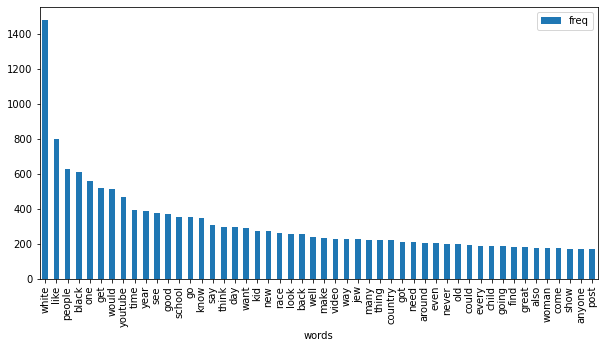

In [37]:
mcw.plot(x="words", y="freq", kind="bar", figsize=(10,5))
plt.show()

#### 3.1 Part of speech (POS)

In [38]:
from textblob import TextBlob
def pos_tag(text):
    try:
        return TextBlob(text).tags
    except:
        return None

In [39]:
print(TextBlob(data.iloc[4]["text_clean"]).tags)
print(TextBlob(data.iloc[4]["stemmed"]).tags)

[('click', 'NN'), ('download', 'NN'), ('megabytes', 'VBZ'), ('green', 'JJ'), ('banner', 'NN'), ('link', 'NN')]
[('click', 'NN'), ('download', 'NN'), ('megabyt', 'NN'), ('green', 'JJ'), ('banner', 'NN'), ('link', 'NN')]


In [40]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [41]:
data['POS_spacy'] = data['lemmatized'].progress_apply(lambda x: [(token.text, token.pos_) for token in nlp(x)])

100%|██████████| 10926/10926 [01:25<00:00, 127.70it/s]


In [42]:
all_pos = data['POS_spacy'].sum()

In [43]:
all_adjs = [x[0] for x in all_pos if x[1] == "ADJ"]
all_nouns = [x[0] for x in all_pos if x[1] == "NOUN"]

In [44]:
hate = data.loc[data["label"] == 1]

In [45]:
hate.shape[0], data.shape[0] # 1428 over 10926 rows

(1428, 10926)

In [46]:
data.label.value_counts()

0    9498
1    1428
Name: label, dtype: int64

In [47]:
all_pos_hate = hate['POS_spacy'].sum()

In [48]:
all_adjs_hate = [x[0] for x in all_pos_hate if x[1] == "ADJ"]
all_nouns_hate = [x[0] for x in all_pos_hate if x[1] == "NOUN"]

In [49]:
adj_counter = {}
for word in all_adjs:
    if word in adj_counter:
        adj_counter[word] += 1
    else:
        adj_counter[word] = 1

top_20_adj = {k: v for k, v in sorted(adj_counter.items(), key=lambda item: item[1], reverse=True)[:20]}
#pd.DataFrame.from_dict(top_20_adj, orient="index", columns=["Freq"]).reset_index()

In [50]:
noun_counter = {}
for word in all_nouns:
    if word in noun_counter:
        noun_counter[word] += 1
    else:
        noun_counter[word] = 1
            
top_20_noun = {k: v for k, v in sorted(noun_counter.items(), key=lambda item: item[1], reverse=True)[:20]}
#pd.DataFrame.from_dict(top_20_noun, orient="index", columns=["Freq"]).reset_index()

In [51]:
adj_counter1 = {}
for word in all_adjs_hate:
    if word in adj_counter1:
        adj_counter1[word] += 1
    else:
        adj_counter1[word] = 1
            
top_20_adj1 = {k: v for k, v in sorted(adj_counter1.items(), key=lambda item: item[1], reverse=True)[:20]}
#pd.DataFrame.from_dict(top_20_adj1, orient="index", columns=["Freq"]).reset_index()

In [52]:
noun_counter1 = {}
for word in all_nouns_hate:
    if word in noun_counter1:
        noun_counter1[word] += 1
    else:
        noun_counter1[word] = 1
            
top_20_noun1 = {k: v for k, v in sorted(noun_counter1.items(), key=lambda item: item[1], reverse=True)[:20]}
#pd.DataFrame.from_dict(top_20_noun1, orient="index", columns=["Freq"]).reset_index()

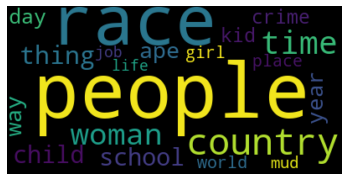

In [53]:
from wordcloud import WordCloud
wc = WordCloud().generate_from_frequencies(top_20_noun1)
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

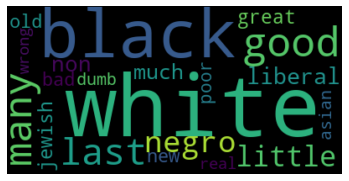

In [54]:
wc = WordCloud().generate_from_frequencies(top_20_adj1)
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [55]:
top_noun = {"Total": top_20_noun.keys(), "Freq_Total": top_20_noun.values(), "Hate_Speech": top_20_noun1.keys(), "Freq_Hate": top_20_noun1.values()}
top_noun = pd.DataFrame(top_noun)
top_noun["R_Freq_Total"] = top_noun.apply(lambda x: np.round(x.Freq_Total / top_noun.Freq_Total.sum(), 3), axis=1)
top_noun["R_Freq_Hate"] = top_noun.apply(lambda x: np.round(x.Freq_Hate / top_noun.Freq_Hate.sum(), 3), axis=1)
top_noun = top_noun.reindex(columns=['Total', 'R_Freq_Total', 'Hate_Speech', 'R_Freq_Hate'])
top_noun

,Total,R_Freq_Total,Hate_Speech,R_Freq_Hate
0,people,0.146,people,0.138
1,time,0.086,race,0.111
2,year,0.085,country,0.087
3,school,0.064,time,0.063
4,race,0.059,woman,0.058
5,day,0.054,thing,0.054
6,thing,0.049,child,0.051
7,country,0.048,school,0.051
8,video,0.044,way,0.043
9,child,0.044,ape,0.043


In [56]:
common_nouns = list(set(top_noun["Hate_Speech"].values).union(set(top_noun["Total"].values)))

In [57]:
freq_common_tot = [noun_counter[x] for x in common_nouns]
freq_common_hate = [noun_counter1[x] for x in common_nouns]

In [58]:
common_noun_df = pd.DataFrame({"Nouns" : common_nouns, "Freq_tot": freq_common_tot, "Freq_Hate_Speech": freq_common_hate })

In [59]:
common_noun_df.sort_values(by=["Freq_Hate_Speech"], ascending= False, inplace=True)

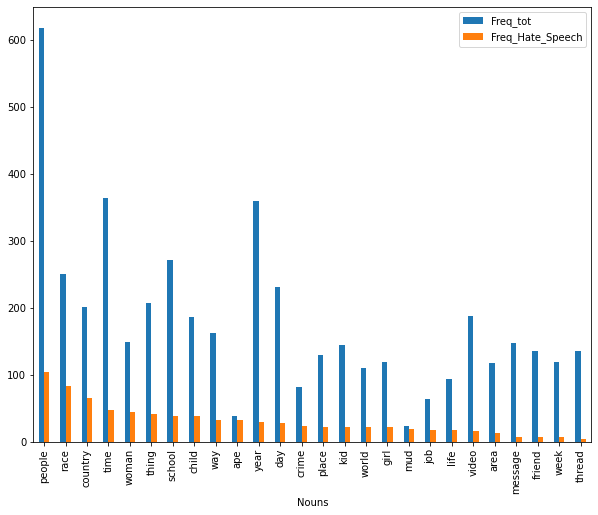

In [60]:
common_noun_df.plot('Nouns', y=['Freq_tot', 'Freq_Hate_Speech'], kind='bar', figsize=(10,8))
plt.show()

In [61]:
top_adj = {"Total": top_20_adj.keys(), "Freq_Total": top_20_adj.values(), "Hate_Speech": top_20_adj1.keys(), "Freq_Hate": top_20_adj1.values()}
top_adj = pd.DataFrame(top_adj)
top_adj["R_Freq_Total"] = top_adj.apply(lambda x: np.round(x.Freq_Total / top_adj.Freq_Total.sum(), 3), axis=1)
top_adj["R_Freq_Hate"] = top_adj.apply(lambda x: np.round(x.Freq_Hate / top_adj.Freq_Hate.sum(), 3), axis=1)
top_adj = top_adj.reindex(columns=['Total', 'R_Freq_Total', 'Hate_Speech', 'R_Freq_Hate'])
top_adj

,Total,R_Freq_Total,Hate_Speech,R_Freq_Hate
0,white,0.244,white,0.290
1,black,0.128,black,0.211
2,good,0.096,good,0.051
3,many,0.064,many,0.046
4,new,0.052,last,0.040
5,old,0.051,negro,0.038
6,last,0.045,little,0.033
7,great,0.042,liberal,0.029
8,little,0.033,non,0.028
9,much,0.032,much,0.027


In [62]:
common_adj = list(set(top_adj["Hate_Speech"].values).union(set(top_adj["Total"].values)))

In [63]:
freq_common_tot_adj = [adj_counter[x] for x in common_adj]
freq_common_hate_adj = [adj_counter1[x] for x in common_adj]

In [64]:
common_adj_df = pd.DataFrame({"Adj" : common_adj, "Freq_tot": freq_common_tot_adj, "Freq_Hate_Speech": freq_common_hate_adj })

In [65]:
common_adj_df.sort_values(by=["Freq_Hate_Speech"], ascending= False, inplace=True)

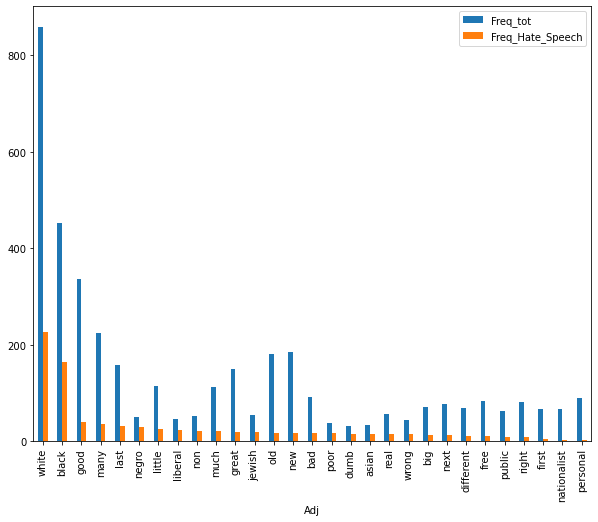

In [66]:
common_adj_df.plot(x='Adj', y=['Freq_tot', 'Freq_Hate_Speech'], kind='bar', figsize=(10,8))
plt.show()

In [67]:
pos_counter = {}
for x in all_pos:
    if x[1] in pos_counter:
        pos_counter[x[1]] += 1
    else:
        pos_counter[x[1]] = 1
        
top_pos = {k: v for k, v in sorted(pos_counter.items(), key=lambda item: item[1], reverse=True)}

In [68]:
freq_pos = pd.DataFrame.from_dict(top_pos, orient="index", columns=["Freq"]).reset_index()
freq_pos["R_Freq"] = freq_pos.apply(lambda x: np.round(x.Freq / freq_pos.Freq.sum(), 2), axis=1)

In [69]:
pos_counter_hate = {}
for x in all_pos_hate:
    if x[1] in pos_counter_hate:
        pos_counter_hate[x[1]] += 1
    else:
        pos_counter_hate[x[1]] = 1
        
top_pos_hate = {k: v for k, v in sorted(pos_counter_hate.items(), key=lambda item: item[1], reverse=True)}

In [70]:
freq_pos_hate = pd.DataFrame.from_dict(top_pos_hate, orient="index", columns=["Freq"]).reset_index()
freq_pos_hate["R_Freq"] = freq_pos_hate.apply(lambda x: np.round(x.Freq / freq_pos_hate.Freq.sum(), 2), axis=1)

In [71]:
compared_pos = {"Total": top_pos.keys(), "Freq_Total": top_pos.values(), "Hate_Speech": top_pos_hate.keys(), "Freq_Hate": top_pos_hate.values()}
compared_pos = pd.DataFrame(compared_pos)
compared_pos["R_Freq_Total"] = compared_pos.apply(lambda x: np.round(x.Freq_Total / compared_pos.Freq_Total.sum(), 3), axis=1)
compared_pos["R_Freq_Hate"] = compared_pos.apply(lambda x: np.round(x.Freq_Hate / compared_pos.Freq_Hate.sum(), 3), axis=1)
compared_pos = compared_pos.reindex(columns=['Total', 'R_Freq_Total', 'Hate_Speech', 'R_Freq_Hate'])
compared_pos[:7]

,Total,R_Freq_Total,Hate_Speech,R_Freq_Hate
0,NOUN,0.291,NOUN,0.284
1,PROPN,0.236,PROPN,0.228
2,VERB,0.205,VERB,0.211
3,ADJ,0.133,ADJ,0.149
4,ADV,0.059,ADV,0.060
5,PRON,0.013,SCONJ,0.012
6,INTJ,0.012,PRON,0.011


# 4. MODELS

In [72]:
tfidf_vectorizer = TfidfVectorizer()
X_class = tfidf_vectorizer.fit_transform(data['lemmatized'])
y_class = data["label"]
X_class.shape

(10926, 12731)

In [73]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.3, random_state=42, stratify=y_class)

In [110]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import sklearn as sk
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
random_state = np.random.RandomState(0)


Multinomial Naive Bayes - Original dataset

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      2850
           1       0.41      0.25      0.31       428

    accuracy                           0.85      3278
   macro avg       0.65      0.60      0.61      3278
weighted avg       0.83      0.85      0.84      3278

0.8544844417327638


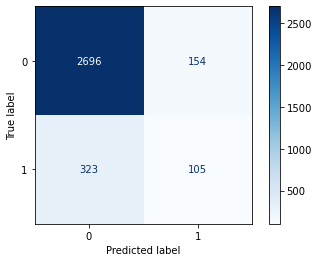

In [75]:
# Multinomial Naive Bayes
mnb = MultinomialNB(alpha=0.01)
mnb.fit(X_train, y_train)
y_mnb = mnb.predict(X_test)
as_mnb = accuracy_score(y_test, y_mnb)
f1s_mnb = f1_score(y_test, y_mnb, average= "macro")
prec_mnb = precision_score(y_test, y_mnb)
rec_mnb = recall_score(y_test, y_mnb, average='macro')
print("\nMultinomial Naive Bayes - Original dataset\n")
plot_confusion_matrix(mnb, X_test,y_test, cmap= "Blues")
#print(confusion_matrix(y_test,y_mnb))
print(classification_report(y_test,y_mnb))
print(accuracy_score(y_test, y_mnb))

[LibSVM]
Support Vector Machine - Original dataset

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      2850
           1       0.88      0.05      0.09       428

    accuracy                           0.87      3278
   macro avg       0.87      0.52      0.51      3278
weighted avg       0.87      0.87      0.82      3278

0.8749237339841367


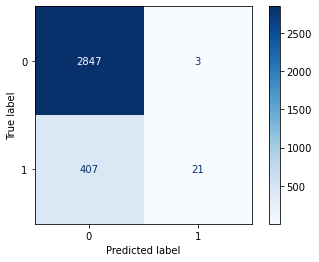

In [76]:
# Support Vector Machine
svc = SVC(verbose=10, random_state=42)
svc.fit(X_train, y_train)
y_svc = svc.predict(X_test)
as_svc = accuracy_score(y_test, y_svc)
f1s_svc = f1_score(y_test, y_svc, average="macro")
prec_svc = precision_score(y_test, y_svc)
rec_svc = recall_score(y_test, y_svc, average='macro')
print("\nSupport Vector Machine - Original dataset\n")
plot_confusion_matrix(svc, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_svc))
print(classification_report(y_test,y_svc))
print(accuracy_score(y_test, y_svc))


Logistic Regression - Original dataset

              precision    recall  f1-score   support

           0       0.88      1.00      0.93      2850
           1       0.72      0.07      0.12       428

    accuracy                           0.87      3278
   macro avg       0.80      0.53      0.53      3278
weighted avg       0.86      0.87      0.83      3278

0.8746186699206834


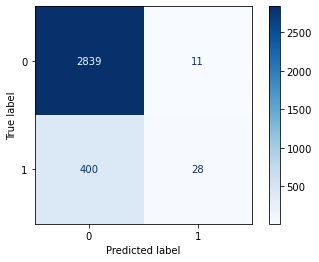

In [77]:
# Logistic
log_fit = LogisticRegression(random_state=42).fit(X_train, y_train)
y_log = log_fit.predict(X_test)
as_log = accuracy_score(y_test, y_log)
f1s_log = f1_score(y_test, y_log, average= "macro")
prec_log = precision_score(y_test, y_log)
rec_log = recall_score(y_test, y_log, average='macro')
print("\nLogistic Regression - Original dataset\n")
plot_confusion_matrix(log_fit, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_log))
print(classification_report(y_test,y_log))
print(accuracy_score(y_test, y_log))


Random Forest - Original dataset

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      2850
           1       0.64      0.11      0.19       428

    accuracy                           0.88      3278
   macro avg       0.76      0.55      0.56      3278
weighted avg       0.85      0.88      0.84      3278

0.8758389261744967


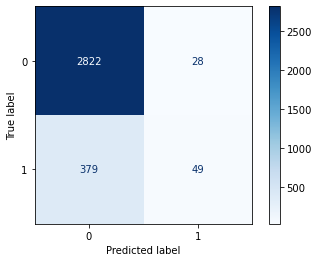

In [78]:
# Random Forest
rf = RandomForestClassifier(n_estimators=10, random_state=42)
rf.fit(X_train, y_train) 
y_rf = rf.predict(X_test)
as_rf = accuracy_score(y_test, y_rf)
f1s_rf = f1_score(y_test, y_rf, average= "macro")
prec_rf = precision_score(y_test, y_rf)
rec_rf = recall_score(y_test, y_rf, average='macro')
print("\nRandom Forest - Original dataset\n")
plot_confusion_matrix(rf, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_rf))
print(classification_report(y_test,y_rf))
print(accuracy_score(y_test, y_rf))

C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(



Neural Networks - Original dataset

              precision    recall  f1-score   support

           0       0.90      0.95      0.92      2850
           1       0.44      0.27      0.33       428

    accuracy                           0.86      3278
   macro avg       0.67      0.61      0.63      3278
weighted avg       0.84      0.86      0.84      3278

0.8593654667480171


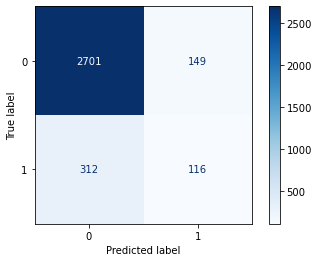

In [79]:
# Neural Networks
NN = MLPClassifier(random_state=42, max_iter=30)
NN.fit(X_train, y_train)
y_NN = NN.predict(X_test)
as_NN = accuracy_score(y_test, y_NN)
f1s_NN = f1_score(y_test, y_NN, average= "macro")
prec_NN = precision_score(y_test, y_NN)
rec_NN = recall_score(y_test, y_NN, average='macro')
print("\nNeural Networks - Original dataset\n")
plot_confusion_matrix(NN, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_NN))
print(classification_report(y_test,y_NN))
print(accuracy_score(y_test, y_NN))


Decision Tree - Original dataset

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      2850
           1       0.41      0.36      0.39       428

    accuracy                           0.85      3278
   macro avg       0.66      0.64      0.65      3278
weighted avg       0.84      0.85      0.84      3278

0.8486882245271506


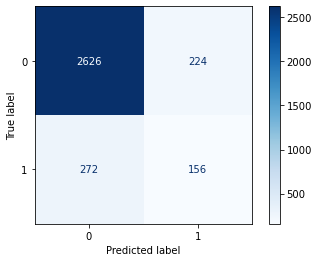

In [80]:
# Decision Tree
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
y_tree = tree.predict(X_test)
as_tree = accuracy_score(y_test, y_tree)
f1s_tree = f1_score(y_test, y_tree, average= "macro")
prec_tree = precision_score(y_test, y_tree)
rec_tree = recall_score(y_test, y_tree, average='macro')
print("\nDecision Tree - Original dataset\n")
plot_confusion_matrix(tree, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_tree))
print(classification_report(y_test,y_tree))
print(accuracy_score(y_test, y_tree))


K-Nearest Neighbors - Original dataset

              precision    recall  f1-score   support

           0       0.87      1.00      0.93      2850
           1       1.00      0.02      0.04       428

    accuracy                           0.87      3278
   macro avg       0.94      0.51      0.49      3278
weighted avg       0.89      0.87      0.82      3278

0.8721781574130567


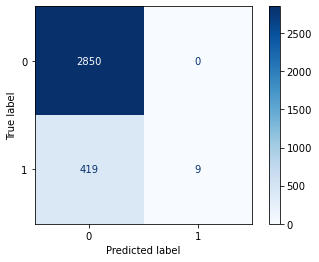

In [81]:
# K-Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_knn = knn.predict(X_test)
as_knn = accuracy_score(y_test, y_knn)
f1s_knn = f1_score(y_test, y_knn, average= "macro")
prec_knn = precision_score(y_test, y_knn)
rec_knn = recall_score(y_test, y_knn, average='macro')
print("\nK-Nearest Neighbors - Original dataset\n")
plot_confusion_matrix(knn, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_knn))
print(classification_report(y_test,y_knn))
print(accuracy_score(y_test, y_knn))

In [82]:
s1 = pd.Series([as_mnb, as_svc, as_log, as_rf, as_NN, as_tree, as_knn], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s2 = pd.Series([f1s_mnb, f1s_svc, f1s_log, f1s_rf, f1s_NN, f1s_tree, f1s_knn], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression','Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s3 = pd.Series([prec_mnb, prec_svc, prec_log, prec_rf, prec_NN, prec_tree, prec_knn], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s4 = pd.Series([rec_mnb, rec_svc, rec_log, rec_rf, rec_NN, rec_tree, rec_knn], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
d = {'Accuracy Score' : s1, 'Precision Score': s3, 'Recall Score' : s4, 'F1 Score' : s2 }
dfm = pd.DataFrame(d)
print("\nOriginal dataset\n")
dfm.style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'tomato', axis = 0)


Original dataset



,Accuracy Score,Precision Score,Recall Score,F1 Score
Multinomial Naive Bayes,0.854484,0.405405,0.595646,0.612201
Support Vector Machine,0.874924,0.875000,0.524006,0.512876
Logistic Regression,0.874619,0.717949,0.530780,0.526208
Random Forest,0.875839,0.636364,0.552331,0.563399
Neural Networks,0.859365,0.437736,0.609374,0.628074
Decision Tree,0.848688,0.410526,0.642945,0.649924
K-Nearest Neighbors,0.872178,1.000000,0.510514,0.486357


# 4.1 Imbalanced

In [83]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler 
undersample = RandomUnderSampler(sampling_strategy='majority', random_state=42)

In [84]:
X_over, y_over = undersample.fit_resample(X_class, y_class)

In [85]:
from collections import Counter
print(Counter(y_over))

Counter({0: 1428, 1: 1428})


In [86]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.3, random_state=42, stratify=y_over)


Multinomoial Naive Bayes - Balanced dataset

              precision    recall  f1-score   support

           0       0.69      0.57      0.62       429
           1       0.63      0.74      0.68       428

    accuracy                           0.65       857
   macro avg       0.66      0.65      0.65       857
weighted avg       0.66      0.65      0.65       857

0.6546091015169195


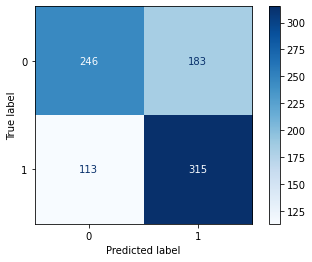

In [87]:
# Multinomial Naive Bayes
mnb_i = MultinomialNB(alpha=0.01)
mnb_i.fit(X_train, y_train)
y_mnb_i = mnb_i.predict(X_test)
as_mnb_i = accuracy_score(y_test, y_mnb_i)
f1s_mnb_i = f1_score(y_test, y_mnb_i, average= "macro")
prec_mnb_i = precision_score(y_test, y_mnb_i)
rec_mnb_i = recall_score(y_test, y_mnb_i, average='macro')
print("\nMultinomoial Naive Bayes - Balanced dataset\n")
plot_confusion_matrix(mnb_i, X_test,y_test, cmap = "Blues")
#print(confusion_matrix(y_test,y_mnb_i))
print(classification_report(y_test,y_mnb_i))
print(accuracy_score(y_test, y_mnb_i))

[LibSVM]
Support Vector Machine - Balanced dataset

              precision    recall  f1-score   support

           0       0.69      0.76      0.73       429
           1       0.74      0.66      0.70       428

    accuracy                           0.71       857
   macro avg       0.72      0.71      0.71       857
weighted avg       0.71      0.71      0.71       857

0.7129521586931156


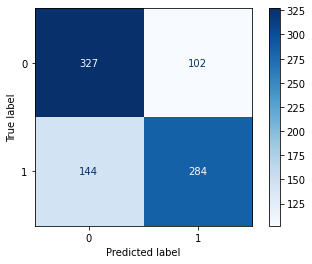

In [88]:
# Support Vector Machine
svc_i = SVC(verbose=10, random_state=42)
svc_i.fit(X_train, y_train)
y_svc_i = svc_i.predict(X_test)
as_svc_i = accuracy_score(y_test, y_svc_i)
f1s_svc_i = f1_score(y_test, y_svc_i, average="macro")
prec_svc_i = precision_score(y_test, y_svc_i)
rec_svc_i = recall_score(y_test, y_svc_i, average='macro')
print("\nSupport Vector Machine - Balanced dataset\n")
plot_confusion_matrix(svc_i, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_svc_i))
print(classification_report(y_test,y_svc_i))
print(accuracy_score(y_test, y_svc_i))


Logistic Regression - Balanced dataset

              precision    recall  f1-score   support

           0       0.70      0.79      0.74       429
           1       0.76      0.67      0.71       428

    accuracy                           0.73       857
   macro avg       0.73      0.73      0.73       857
weighted avg       0.73      0.73      0.73       857

0.7269544924154026


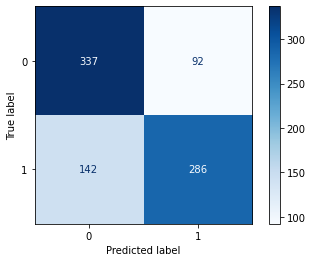

In [89]:
# Logistic
log_fit_i = LogisticRegression(random_state=42).fit(X_train, y_train)
y_log_i = log_fit_i.predict(X_test)
as_log_i = accuracy_score(y_test, y_log_i)
f1s_log_i = f1_score(y_test, y_log_i, average= "macro")
prec_log_i = precision_score(y_test, y_log_i)
rec_log_i = recall_score(y_test, y_log_i, average='macro')
print("\nLogistic Regression - Balanced dataset\n")
plot_confusion_matrix(log_fit_i, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_log_i))
print(classification_report(y_test,y_log_i))
print(accuracy_score(y_test, y_log_i))


Random Forest - Balanced dataset

              precision    recall  f1-score   support

           0       0.66      0.79      0.72       429
           1       0.73      0.59      0.65       428

    accuracy                           0.69       857
   macro avg       0.70      0.69      0.69       857
weighted avg       0.70      0.69      0.69       857

0.6884480746791132


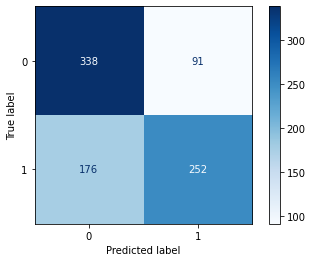

In [90]:
# Random Forest
rf_i = RandomForestClassifier(n_estimators=10, random_state=42)
rf_i.fit(X_train, y_train) 
y_rf_i = rf_i.predict(X_test)
as_rf_i = accuracy_score(y_test, y_rf_i)
f1s_rf_i = f1_score(y_test, y_rf_i, average= "macro")
prec_rf_i = precision_score(y_test, y_rf_i)
rec_rf_i = recall_score(y_test, y_rf_i, average='macro')
print("\nRandom Forest - Balanced dataset\n")
plot_confusion_matrix(rf_i, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_rf_i))
print(classification_report(y_test,y_rf_i))
print(accuracy_score(y_test, y_rf_i))

C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(



Neural Networks - Balanced dataset

              precision    recall  f1-score   support

           0       0.69      0.73      0.71       429
           1       0.71      0.67      0.69       428

    accuracy                           0.70       857
   macro avg       0.70      0.70      0.70       857
weighted avg       0.70      0.70      0.70       857

0.7001166861143524


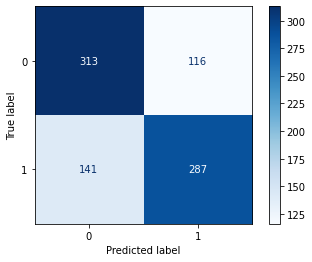

In [91]:
# Neural Networks
NN_i = MLPClassifier(random_state=42, max_iter=30)
NN_i.fit(X_train, y_train)
#NN.score(X_test, y_test)
y_NN_i = NN_i.predict(X_test)
as_NN_i = accuracy_score(y_test, y_NN_i)
f1s_NN_i = f1_score(y_test, y_NN_i, average= "macro")
prec_NN_i = precision_score(y_test, y_NN_i)
rec_NN_i = recall_score(y_test, y_NN_i, average='macro')
print("\nNeural Networks - Balanced dataset\n")
plot_confusion_matrix(NN_i, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_NN_i))
print(classification_report(y_test,y_NN_i))
print(accuracy_score(y_test, y_NN_i))


Decision Tree - Balanced dataset

              precision    recall  f1-score   support

           0       0.67      0.70      0.69       429
           1       0.69      0.66      0.67       428

    accuracy                           0.68       857
   macro avg       0.68      0.68      0.68       857
weighted avg       0.68      0.68      0.68       857

0.6814469078179697


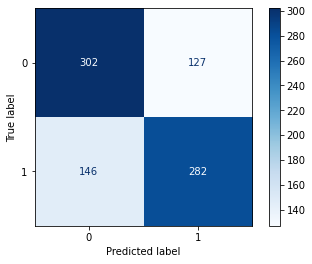

In [92]:
# Decision Tree
tree_i = DecisionTreeClassifier(random_state=42)
tree_i.fit(X_train, y_train)
y_tree_i = tree_i.predict(X_test)
as_tree_i = accuracy_score(y_test, y_tree_i)
f1s_tree_i = f1_score(y_test, y_tree_i, average= "macro")
prec_tree_i = precision_score(y_test, y_tree_i)
rec_tree_i = recall_score(y_test, y_tree_i, average='macro')
print("\nDecision Tree - Balanced dataset\n")
plot_confusion_matrix(tree_i, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_tree_i))
print(classification_report(y_test,y_tree_i))
print(accuracy_score(y_test, y_tree_i))


K-Nearest Neighbors - Balanced dataset

              precision    recall  f1-score   support

           0       0.51      0.99      0.67       429
           1       0.81      0.03      0.06       428

    accuracy                           0.51       857
   macro avg       0.66      0.51      0.36       857
weighted avg       0.66      0.51      0.37       857

0.5122520420070011


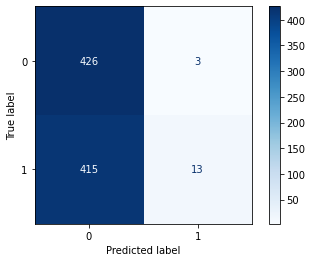

In [93]:
# K-Nearest Neighbors
knn_i = KNeighborsClassifier()
knn_i.fit(X_train, y_train)
y_knn_i = knn_i.predict(X_test)
as_knn_i = accuracy_score(y_test, y_knn_i)
f1s_knn_i = f1_score(y_test, y_knn_i, average= "macro")
prec_knn_i = precision_score(y_test, y_knn_i)
rec_knn_i = recall_score(y_test, y_knn_i, average='macro')
print("\nK-Nearest Neighbors - Balanced dataset\n")
plot_confusion_matrix(knn_i, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_knn_i))
print(classification_report(y_test,y_knn_i))
print(accuracy_score(y_test, y_knn_i))

In [94]:
s1_i = pd.Series([as_mnb_i, as_svc_i, as_log_i, as_rf_i, as_NN_i, as_tree_i, as_knn_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s2_i = pd.Series([f1s_mnb_i, f1s_svc_i, f1s_log_i, f1s_rf_i, f1s_NN_i, f1s_tree_i, f1s_knn_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression','Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s3_i = pd.Series([prec_mnb_i, prec_svc_i, prec_log_i, prec_rf_i, prec_NN_i, prec_tree_i, prec_knn_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s4_i = pd.Series([rec_mnb_i, rec_svc_i, rec_log_i, rec_rf_i, rec_NN_i, rec_tree_i, rec_knn_i], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
d_i = {'Accuracy Score' : s1_i, 'Precision Score': s3_i, 'Recall Score' : s4_i, 'F1 Score' : s2_i}
dfm_i = pd.DataFrame(d_i)
print("\nBalanced dataset\n")
dfm_i.style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'tomato', axis = 0)


Balanced dataset



,Accuracy Score,Precision Score,Recall Score,F1 Score
Multinomial Naive Bayes,0.654609,0.632530,0.654704,0.652356
Support Vector Machine,0.712952,0.735751,0.712895,0.712228
Logistic Regression,0.726954,0.756614,0.726886,0.725984
Random Forest,0.688448,0.734694,0.688332,0.685279
Neural Networks,0.700117,0.712159,0.700082,0.699840
Decision Tree,0.681447,0.689487,0.681421,0.681273
K-Nearest Neighbors,0.512252,0.812500,0.511690,0.364712


## 4.2 Models on POS

In [95]:
def filter_text_pos(x):
    final_pos_text = []
    for elem in x:
        for pos in pos_list:
            if elem[1] == pos:
                final_pos_text.append(elem[0])
    
    return " ".join(final_pos_text)

### 4.2.1 Nouns + Proper Nouns + Adjectives + Adverbs

In [96]:
pos_list = ["NOUN" , "PROPN" ,"ADJ" , "ADV"]

In [97]:
data["NOUN_PROPN_ADJ_ADV"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)

In [98]:
tfidf_vectorizer = TfidfVectorizer()
X_Propn = tfidf_vectorizer.fit_transform(data["NOUN_PROPN_ADJ_ADV"])
y_Propn = data["label"]
X_Propn.shape

(10926, 10894)

In [99]:
X_over_p, y_over_p = undersample.fit_resample(X_Propn, y_Propn)

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X_over_p, y_over_p, test_size=0.3, random_state=42, stratify=y_over_p)


Multinomoial Naive Bayes - NOUN_PROPN_ADJ_ADV

              precision    recall  f1-score   support

           0       0.69      0.55      0.62       429
           1       0.63      0.75      0.68       428

    accuracy                           0.65       857
   macro avg       0.66      0.65      0.65       857
weighted avg       0.66      0.65      0.65       857

0.6534422403733956


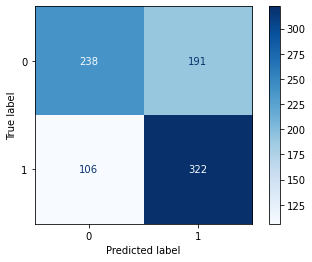

In [101]:
# Multinomial Naive Bayes
mnb_p = MultinomialNB(alpha=0.01)
mnb_p.fit(X_train, y_train)
y_mnb_p = mnb_p.predict(X_test)
as_mnb_p = accuracy_score(y_test, y_mnb_p)
f1s_mnb_p = f1_score(y_test, y_mnb_p, average= "macro")
prec_mnb_p = precision_score(y_test, y_mnb_p)
rec_mnb_p = recall_score(y_test, y_mnb_p, average='macro')
print("\nMultinomoial Naive Bayes - NOUN_PROPN_ADJ_ADV\n")
plot_confusion_matrix(mnb_p, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_mnb_p))
print(classification_report(y_test,y_mnb_p))
print(accuracy_score(y_test, y_mnb_p))

[LibSVM]
Support Vector Machine - NOUN_PROPN_ADJ_ADV

              precision    recall  f1-score   support

           0       0.70      0.75      0.72       429
           1       0.73      0.68      0.71       428

    accuracy                           0.72       857
   macro avg       0.72      0.72      0.71       857
weighted avg       0.72      0.72      0.71       857

0.7152858809801633


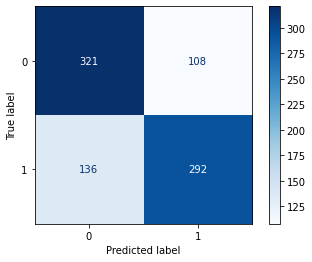

In [102]:
# Support Vector Machine
svc_p = SVC(verbose=10, random_state=42)
svc_p.fit(X_train, y_train)
y_svc_p = svc_p.predict(X_test)
as_svc_p = accuracy_score(y_test, y_svc_p)
f1s_svc_p = f1_score(y_test, y_svc_p, average="macro")
prec_svc_p = precision_score(y_test, y_svc_p)
rec_svc_p = recall_score(y_test, y_svc_p, average='macro')
print("\nSupport Vector Machine - NOUN_PROPN_ADJ_ADV\n")
plot_confusion_matrix(svc_p, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_svc_p))
print(classification_report(y_test,y_svc_p))
print(accuracy_score(y_test, y_svc_p))


Logistic Regression - NOUN_PROPN_ADJ_ADV

              precision    recall  f1-score   support

           0       0.71      0.78      0.74       429
           1       0.76      0.68      0.72       428

    accuracy                           0.73       857
   macro avg       0.73      0.73      0.73       857
weighted avg       0.73      0.73      0.73       857

0.7304550758459744


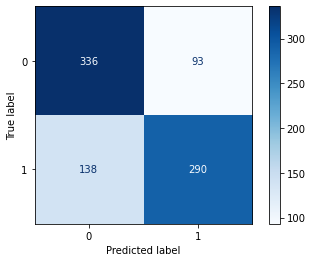

In [103]:
# Logistic
log_fit_p = LogisticRegression(random_state=42).fit(X_train, y_train)
y_log_p = log_fit_p.predict(X_test)
as_log_p = accuracy_score(y_test, y_log_p)
f1s_log_p = f1_score(y_test, y_log_p, average= "macro")
prec_log_p = precision_score(y_test, y_log_p)
rec_log_p = recall_score(y_test, y_log_p, average='macro')
print("\nLogistic Regression - NOUN_PROPN_ADJ_ADV\n")
plot_confusion_matrix(log_fit_p, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_log_p))
print(classification_report(y_test,y_log_p))
print(accuracy_score(y_test, y_log_p))


Random Forest - NOUN_PROPN_ADJ_ADV

              precision    recall  f1-score   support

           0       0.69      0.82      0.75       429
           1       0.78      0.64      0.70       428

    accuracy                           0.73       857
   macro avg       0.74      0.73      0.73       857
weighted avg       0.74      0.73      0.73       857

0.7281213535589265


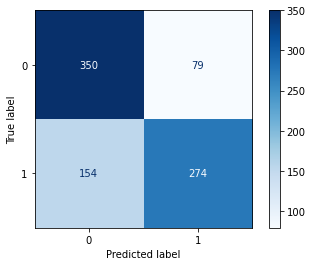

In [104]:
# Random Forest
rf_p = RandomForestClassifier(n_estimators=10, random_state=42)
rf_p.fit(X_train, y_train) 
y_rf_p = rf_p.predict(X_test)
as_rf_p = accuracy_score(y_test, y_rf_p)
f1s_rf_p = f1_score(y_test, y_rf_p, average= "macro")
prec_rf_p = precision_score(y_test, y_rf_p)
rec_rf_p = recall_score(y_test, y_rf_p, average='macro')
print("\nRandom Forest - NOUN_PROPN_ADJ_ADV\n")
plot_confusion_matrix(rf_p, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_rf_p))
print(classification_report(y_test,y_rf_p))
print(accuracy_score(y_test, y_rf_p))

C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(



Neural Networks - NOUN_PROPN_ADJ_ADV

              precision    recall  f1-score   support

           0       0.68      0.69      0.68       429
           1       0.68      0.68      0.68       428

    accuracy                           0.68       857
   macro avg       0.68      0.68      0.68       857
weighted avg       0.68      0.68      0.68       857

0.6826137689614936


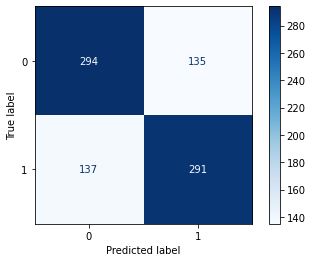

In [105]:
# Neural Networks
NN_p = MLPClassifier(random_state=42, max_iter=30)
NN_p.fit(X_train, y_train)
y_NN_p = NN_p.predict(X_test)
as_NN_p = accuracy_score(y_test, y_NN_p)
f1s_NN_p = f1_score(y_test, y_NN_p, average= "macro")
prec_NN_p = precision_score(y_test, y_NN_p)
rec_NN_p = recall_score(y_test, y_NN_p, average='macro')
print("\nNeural Networks - NOUN_PROPN_ADJ_ADV\n")
plot_confusion_matrix(NN_p, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_NN_p))
print(classification_report(y_test,y_NN_p))
print(accuracy_score(y_test, y_NN_p))


Decision Tree - NOUN_PROPN_ADJ_ADV

              precision    recall  f1-score   support

           0       0.68      0.72      0.70       429
           1       0.70      0.66      0.68       428

    accuracy                           0.69       857
   macro avg       0.69      0.69      0.69       857
weighted avg       0.69      0.69      0.69       857

0.6931155192532089


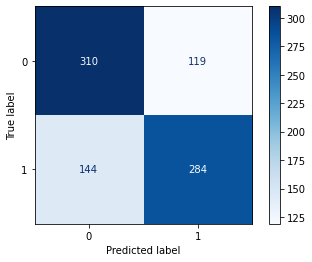

In [106]:
# Decision Tree
tree_p = DecisionTreeClassifier(random_state=42)
tree_p.fit(X_train, y_train)
y_tree_p = tree_p.predict(X_test)
as_tree_p = accuracy_score(y_test, y_tree_p)
f1s_tree_p = f1_score(y_test, y_tree_p, average= "macro")
prec_tree_p = precision_score(y_test, y_tree_p)
rec_tree_p = recall_score(y_test, y_tree_p, average='macro')
print("\nDecision Tree - NOUN_PROPN_ADJ_ADV\n")
plot_confusion_matrix(tree_p, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_tree_p))
print(classification_report(y_test,y_tree_p))
print(accuracy_score(y_test, y_tree_p))


K-Nearest Neighbors - NOUN_PROPN_ADJ_ADV

              precision    recall  f1-score   support

           0       0.51      0.98      0.67       429
           1       0.74      0.06      0.11       428

    accuracy                           0.52       857
   macro avg       0.62      0.52      0.39       857
weighted avg       0.62      0.52      0.39       857

0.5192532088681447


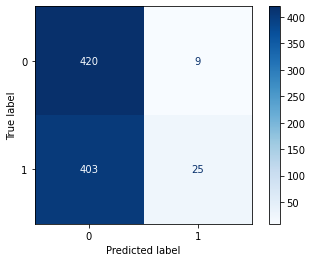

In [107]:
# K-Nearest Neighbors
knn_p = KNeighborsClassifier()
knn_p.fit(X_train, y_train)
y_knn_p = knn_p.predict(X_test)
as_knn_p = accuracy_score(y_test, y_knn_p)
f1s_knn_p = f1_score(y_test, y_knn_p, average= "macro")
prec_knn_p = precision_score(y_test, y_knn_p)
rec_knn_p = recall_score(y_test, y_knn_p, average='macro')
print("\nK-Nearest Neighbors - NOUN_PROPN_ADJ_ADV\n")
plot_confusion_matrix(knn_p, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_knn_p))
print(classification_report(y_test,y_knn_p))
print(accuracy_score(y_test, y_knn_p))

In [108]:
s1_p = pd.Series([as_mnb_p, as_svc_p, as_log_p, as_rf_p, as_NN_p, as_tree_p, as_knn_p], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s2_p = pd.Series([f1s_mnb_p, f1s_svc_p, f1s_log_p, f1s_rf_p, f1s_NN_p, f1s_tree_p, f1s_knn_p], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression','Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s3_p = pd.Series([prec_mnb_p, prec_svc_p, prec_log_p, prec_rf_p, prec_NN_p, prec_tree_p, prec_knn_p], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s4_p = pd.Series([rec_mnb_p, rec_svc_p, rec_log_p, rec_rf_p, rec_NN_p, rec_tree_p, rec_knn_p], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
d_p = {'Accuracy Score' : s1_p, 'Precision Score': s3_p, 'Recall Score' : s4_p, 'F1 Score' : s2_p}
dfm_p = pd.DataFrame(d_p)
print("\nNOUN_PROPN_ADJ_ADV\n")
dfm_p.style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'tomato', axis = 0)


NOUN_PROPN_ADJ_ADV



,Accuracy Score,Precision Score,Recall Score,F1 Score
Multinomial Naive Bayes,0.653442,0.627680,0.653558,0.650080
Support Vector Machine,0.715286,0.730000,0.715247,0.714959
Logistic Regression,0.730455,0.757180,0.730393,0.729676
Random Forest,0.728121,0.776204,0.728019,0.725966
Neural Networks,0.682614,0.683099,0.682611,0.682610
Decision Tree,0.693116,0.704715,0.693081,0.692833
K-Nearest Neighbors,0.519253,0.735294,0.518716,0.389576


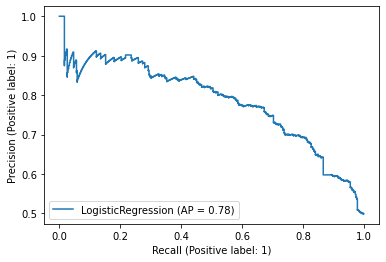

In [111]:
plot_precision_recall_curve(log_fit_p, X_test, y_test)

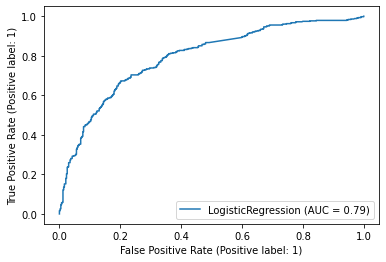

In [112]:
plot_roc_curve(log_fit_p,  X_test, y_test)

### 4.2.2 Nouns + Proper Nouns + Verbs + Adjectives + Adverbs

In [113]:
pos_list = ["NOUN","PROPN", "VERB", "ADJ", "ADV"]

In [114]:
data["NOUN_PROPN_VERB_ADJ_ADV"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)

In [115]:
tfidf_vectorizer = TfidfVectorizer()
X_NounPropnVerb = tfidf_vectorizer.fit_transform(data["NOUN_PROPN_VERB_ADJ_ADV"])
y_NounPropnVerb = data["label"]
X_NounPropnVerb.shape

(10926, 12565)

In [116]:
X_over_n, y_over_n = undersample.fit_resample(X_NounPropnVerb, y_NounPropnVerb)

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X_over_n, y_over_n, test_size=0.3, random_state=42, stratify=y_over_n)


Multinomoial Naive Bayes - NOUN_PROPN_VERB_ADJ_ADV

              precision    recall  f1-score   support

           0       0.68      0.56      0.62       429
           1       0.63      0.74      0.68       428

    accuracy                           0.65       857
   macro avg       0.65      0.65      0.65       857
weighted avg       0.65      0.65      0.65       857

0.6499416569428238


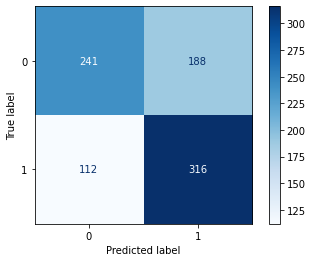

In [118]:
# Multinomial Naive Bayes
mnb_n = MultinomialNB(alpha=0.01)
mnb_n.fit(X_train, y_train)
y_mnb_n = mnb_n.predict(X_test)
as_mnb_n = accuracy_score(y_test, y_mnb_n)
f1s_mnb_n = f1_score(y_test, y_mnb_n, average= "macro")
prec_mnb_n = precision_score(y_test, y_mnb_n)
rec_mnb_n = recall_score(y_test, y_mnb_n, average='macro')
print("\nMultinomoial Naive Bayes - NOUN_PROPN_VERB_ADJ_ADV\n")
plot_confusion_matrix(mnb_n, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_mnb_n))
print(classification_report(y_test,y_mnb_n))
print(accuracy_score(y_test, y_mnb_n))

[LibSVM]
Support Vector Machine - NOUN_PROPN_VERB_ADJ_ADV

              precision    recall  f1-score   support

           0       0.70      0.76      0.73       429
           1       0.74      0.67      0.70       428

    accuracy                           0.71       857
   macro avg       0.72      0.71      0.71       857
weighted avg       0.72      0.71      0.71       857

0.7141190198366394


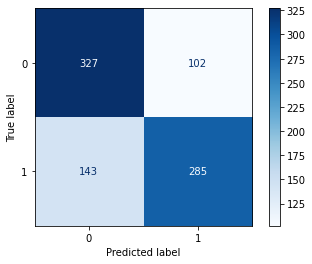

In [119]:
# Support Vector Machine
svc_n = SVC(verbose=10, random_state=42)
svc_n.fit(X_train, y_train)
y_svc_n = svc_n.predict(X_test)
as_svc_n = accuracy_score(y_test, y_svc_n)
f1s_svc_n = f1_score(y_test, y_svc_n, average="macro")
prec_svc_n = precision_score(y_test, y_svc_n)
rec_svc_n = recall_score(y_test, y_svc_n, average='macro')
print("\nSupport Vector Machine - NOUN_PROPN_VERB_ADJ_ADV\n")
plot_confusion_matrix(svc_n, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_svc_n)
print(classification_report(y_test,y_svc_n))
print(accuracy_score(y_test, y_svc_n))


Logistic Regression - NOUN_PROPN_VERB_ADJ_ADV

              precision    recall  f1-score   support

           0       0.71      0.78      0.74       429
           1       0.76      0.68      0.72       428

    accuracy                           0.73       857
   macro avg       0.73      0.73      0.73       857
weighted avg       0.73      0.73      0.73       857

0.7304550758459744


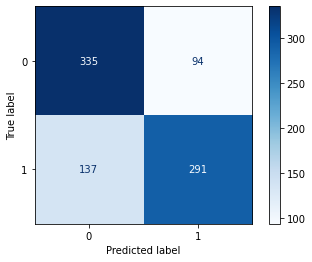

In [120]:
# Logistic
log_fit_n = LogisticRegression(random_state=42).fit(X_train, y_train)
y_log_n = log_fit_n.predict(X_test)
as_log_n = accuracy_score(y_test, y_log_n)
f1s_log_n = f1_score(y_test, y_log_n, average= "macro")
prec_log_n = precision_score(y_test, y_log_n)
rec_log_n = recall_score(y_test, y_log_n, average='macro')
print("\nLogistic Regression - NOUN_PROPN_VERB_ADJ_ADV\n")
plot_confusion_matrix(log_fit_n, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_log_n))
print(classification_report(y_test,y_log_n))
print(accuracy_score(y_test, y_log_n))


Random Forest - NOUN_PROPN_VERB_ADJ_ADV

              precision    recall  f1-score   support

           0       0.64      0.78      0.71       429
           1       0.72      0.57      0.63       428

    accuracy                           0.67       857
   macro avg       0.68      0.67      0.67       857
weighted avg       0.68      0.67      0.67       857

0.6744457409568262


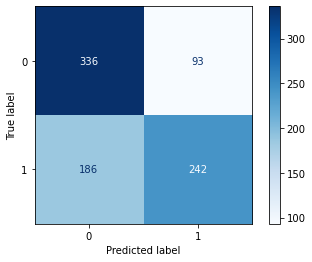

In [121]:
# Random Forest
rf_n = RandomForestClassifier(n_estimators=10, random_state=42)
rf_n.fit(X_train, y_train) 
y_rf_n = rf_n.predict(X_test)
as_rf_n = accuracy_score(y_test, y_rf_n)
f1s_rf_n = f1_score(y_test, y_rf_n, average= "macro")
prec_rf_n = precision_score(y_test, y_rf_n)
rec_rf_n = recall_score(y_test, y_rf_n, average='macro')
print("\nRandom Forest - NOUN_PROPN_VERB_ADJ_ADV\n")
plot_confusion_matrix(rf_n, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_rf_n))
print(classification_report(y_test,y_rf_n))
print(accuracy_score(y_test, y_rf_n))

C:\Users\marti\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(



Neural Networks - NOUN_PROPN_VERB_ADJ_ADV

              precision    recall  f1-score   support

           0       0.70      0.71      0.70       429
           1       0.70      0.69      0.70       428

    accuracy                           0.70       857
   macro avg       0.70      0.70      0.70       857
weighted avg       0.70      0.70      0.70       857

0.7001166861143524


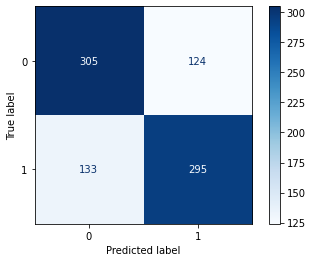

In [122]:
# Neural Networks
NN_n = MLPClassifier(random_state=42, max_iter=30)
NN_n.fit(X_train, y_train)
y_NN_n = NN_n.predict(X_test)
as_NN_n = accuracy_score(y_test, y_NN_n)
f1s_NN_n = f1_score(y_test, y_NN_n, average= "macro")
prec_NN_n = precision_score(y_test, y_NN_n)
rec_NN_n = recall_score(y_test, y_NN_n, average='macro')
print("\nNeural Networks - NOUN_PROPN_VERB_ADJ_ADV\n")
plot_confusion_matrix(NN_n, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_NN_n))
print(classification_report(y_test,y_NN_n))
print(accuracy_score(y_test, y_NN_n))


Decision Tree - NOUN_PROPN_VERB_ADJ_ADV

              precision    recall  f1-score   support

           0       0.68      0.69      0.68       429
           1       0.68      0.67      0.68       428

    accuracy                           0.68       857
   macro avg       0.68      0.68      0.68       857
weighted avg       0.68      0.68      0.68       857

0.6802800466744457


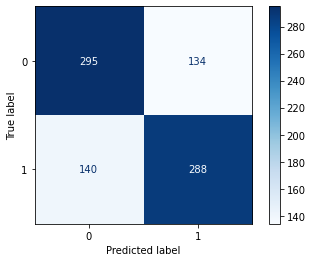

In [123]:
# Decision Tree
tree_n = DecisionTreeClassifier(random_state=42)
tree_n.fit(X_train, y_train)
y_tree_n = tree_n.predict(X_test)
as_tree_n = accuracy_score(y_test, y_tree_n)
f1s_tree_n = f1_score(y_test, y_tree_n, average= "macro")
prec_tree_n = precision_score(y_test, y_tree_n)
rec_tree_n = recall_score(y_test, y_tree_n, average='macro')
print("\nDecision Tree - NOUN_PROPN_VERB_ADJ_ADV\n")
plot_confusion_matrix(tree_n, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_tree_n))
print(classification_report(y_test,y_tree_n))
print(accuracy_score(y_test, y_tree_n))


K-Nearest Neighbors - NOUN_PROPN_VERB_ADJ_ADV

              precision    recall  f1-score   support

           0       0.51      0.98      0.67       429
           1       0.75      0.05      0.09       428

    accuracy                           0.52       857
   macro avg       0.63      0.52      0.38       857
weighted avg       0.63      0.52      0.38       857

0.5169194865810969


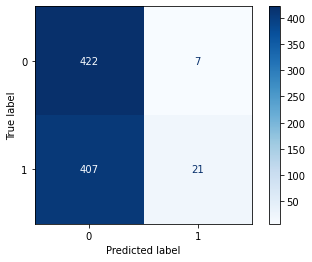

In [124]:
# K-Nearest Neighbors
knn_n = KNeighborsClassifier()
knn_n.fit(X_train, y_train)
y_knn_n = knn_n.predict(X_test)
as_knn_n = accuracy_score(y_test, y_knn_n)
f1s_knn_n = f1_score(y_test, y_knn_n, average= "macro")
prec_knn_n = precision_score(y_test, y_knn_n)
rec_knn_n = recall_score(y_test, y_knn_n, average='macro')
print("\nK-Nearest Neighbors - NOUN_PROPN_VERB_ADJ_ADV\n")
plot_confusion_matrix(knn_n, X_test,y_test, cmap="Blues")
#print(confusion_matrix(y_test,y_knn_n))
print(classification_report(y_test,y_knn_n))
print(accuracy_score(y_test, y_knn_n))

In [125]:
s1_n = pd.Series([as_mnb_n, as_svc_n, as_log_n, as_rf_n, as_NN_n, as_tree_n, as_knn_n], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s2_n = pd.Series([f1s_mnb_n, f1s_svc_n, f1s_log_n, f1s_rf_n, f1s_NN_n, f1s_tree_n, f1s_knn_n], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression','Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s3_n = pd.Series([prec_mnb_n, prec_svc_n, prec_log_n, prec_rf_n, prec_NN_n, prec_tree_n, prec_knn_n], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
s4_n = pd.Series([rec_mnb_n, rec_svc_n, rec_log_n, rec_rf_n, rec_NN_n, rec_tree_n, rec_knn_n], index=['Multinomial Naive Bayes', 'Support Vector Machine', 'Logistic Regression', 'Random Forest', 'Neural Networks', 'Decision Tree', 'K-Nearest Neighbors'])
d_n = {'Accuracy Score' : s1_n, 'Precision Score': s3_n, 'Recall Score' : s4_n, 'F1 Score' : s2_n}
dfm_n = pd.DataFrame(d_n)
print("\nNOUN_PROPN_VERB_ADJ_ADV\n")
dfm_n.style.highlight_max(color = 'lightgreen', axis = 0).highlight_min(color = 'tomato', axis = 0)


NOUN_PROPN_VERB_ADJ_ADV



,Accuracy Score,Precision Score,Recall Score,F1 Score
Multinomial Naive Bayes,0.649942,0.626984,0.650045,0.647240
Support Vector Machine,0.714119,0.736434,0.714063,0.713431
Logistic Regression,0.730455,0.755844,0.730396,0.729743
Random Forest,0.674446,0.722388,0.674319,0.670481
Neural Networks,0.700117,0.704057,0.700104,0.700076
Decision Tree,0.680280,0.682464,0.680271,0.680259
K-Nearest Neighbors,0.516919,0.750000,0.516374,0.381506


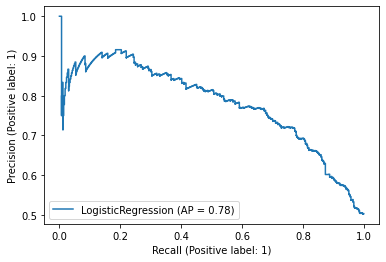

In [126]:
plot_precision_recall_curve(log_fit_n, X_test, y_test)

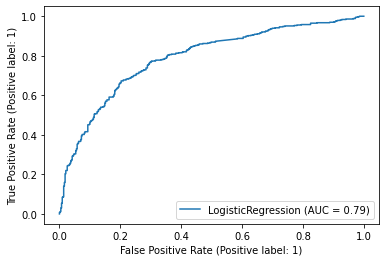

In [127]:
plot_roc_curve(log_fit_n,  X_test, y_test)

### Sentiment Analysis by nltk VEDER 

In [128]:
sia = vd.SentimentIntensityAnalyzer()
data['sentiment_text'] = data["lemmatized"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_text']
correl_text = col1.corr(col2)
print(correl_text)

-0.1143327140569865


In [130]:
data['sentiment_NPAA'] = data["NOUN_PROPN_ADJ_ADV"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NPAA']
correl_NPV = col1.corr(col2)
print(correl_NPV)

-0.10913545634508229


In [131]:
pos_list = ["ADJ"]
data["ADJ"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_ADJ'] = data["ADJ"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_ADJ']
correl_ADJ = col1.corr(col2)
print(correl_ADJ)

-0.08791668104919677


In [132]:
pos_list = ["NOUN"]
data["NOUN"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_NOUN'] = data["NOUN"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_NOUN']
correl_NOUN = col1.corr(col2)
print(correl_NOUN)

-0.07076059713818643


In [133]:
pos_list = ["VERB"]
data["VERB"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_VERB'] = data["VERB"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_VERB']
correl_VERB = col1.corr(col2)
print(correl_VERB)

-0.06372538235181831


In [139]:
pos_list = ["PROPN"]
data["PROPN"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)
data['sentiment_PROPN'] = data["PROPN"].apply(lambda x: sum([sia.polarity_scores(i)['compound'] for i in word_tokenize(x)]))
col1 = data['label']
col2 = data['sentiment_PROPN']
correl_PROPN = col1.corr(col2)
print(correl_PROPN)

-0.045808163551427854


### Polarity by TextBlob

Text(0, 0.5, 'Number of texts')

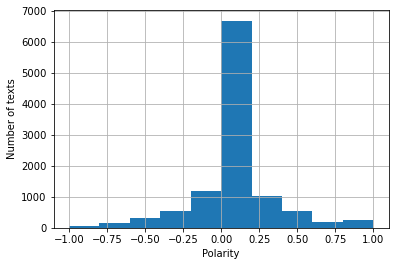

In [140]:
data['polarity'] = data['lemmatized'].map(lambda text: TextBlob(text).sentiment.polarity)
data['polarity'].unique()
data['polarity'].hist()
plt.xlabel("Polarity")
plt.ylabel("Number of texts")

Text(0, 0.5, 'Number of NPAA')

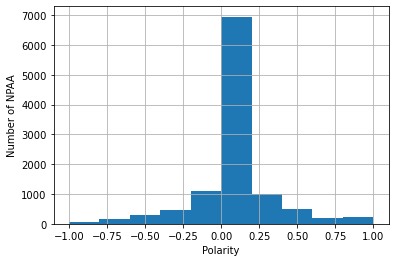

In [145]:
data['polarity_NPAA'] = data["NOUN_PROPN_ADJ_ADV"].map(lambda text: TextBlob(text).sentiment.polarity)
data['polarity_NPAA'].hist()
plt.xlabel("Polarity")
plt.ylabel("Number of NPAA")

Text(0, 0.5, 'Number of Adjectives')

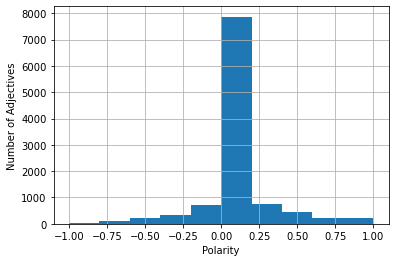

In [141]:
data['polarity_ADJ'] = data['ADJ'].map(lambda text: TextBlob(text).sentiment.polarity)
data['polarity_ADJ'].hist()
plt.xlabel("Polarity")
plt.ylabel("Number of Adjectives")

Text(0, 0.5, 'Number of Nouns')

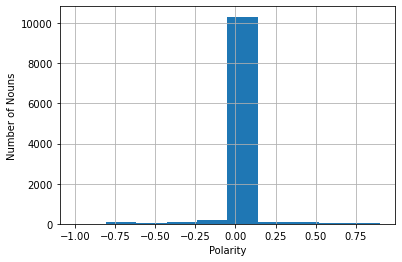

In [142]:
data['polarity_NOUN'] = data['NOUN'].map(lambda text: TextBlob(text).sentiment.polarity)
data['polarity_NOUN'].hist()
plt.xlabel("Polarity")
plt.ylabel("Number of Nouns")

Text(0, 0.5, 'Number of Proper Nouns')

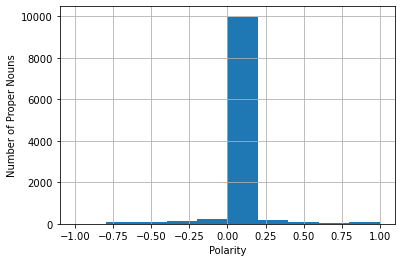

In [143]:
data['polarity_PROPN'] = data['PROPN'].map(lambda text: TextBlob(text).sentiment.polarity)
data['polarity_PROPN'].hist()
plt.xlabel("Polarity")
plt.ylabel("Number of Proper Nouns")

Text(0, 0.5, 'Number of Verbs')

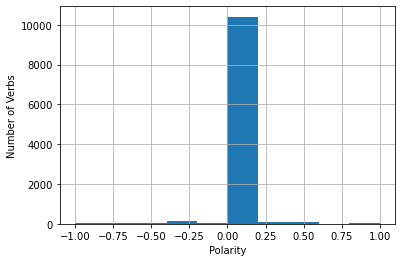

In [144]:
data['polarity_VERB'] = data['VERB'].map(lambda text: TextBlob(text).sentiment.polarity)
data['polarity_VERB'].hist()
plt.xlabel("Polarity")
plt.ylabel("Number of Verbs")

#### Check for punctuation (POS=PUNCT)

In [146]:
pos_list = ["PUNCT"]

In [147]:
data["PUNCT"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)

In [148]:
data[data['PUNCT'].str.contains(".")].head()

,file_id,user_id,subforum_id,num_contexts,label,text,text_clean,word_count,stemmed,lemmatized,...,sentiment_VERB,PROPN,sentiment_PROPN,polarity,polarity_ADJ,polarity_NOUN,polarity_PROPN,polarity_VERB,polarity_NPAA,PUNCT
1184,13052957_1,579087,1345,1,0,I bet all the Ted Pike stuff is on the ADL hit...,bet ted pike stuff adl hit list look start dis...,12,bet ted pike stuff adl hit list look start dis...,bet ted pike stuff adl hit list look start dis...,...,0.0,bet ted pike,0.0,0.000000,0.0000,0.0,0.0,0.0,0.000000,adl
1220,13350432_1,576002,1345,1,0,:hide And if you 're around Knights of Columbu...,around knights columbus roman catholic brether...,13,around knight columbu roman cathol brethern ke...,around knight columbus roman catholic brethern...,...,0.0,knight columbus roman catholic brethern,0.0,0.088889,0.1000,0.0,0.0,0.0,0.088889,boy
1495,14014774_2,579541,1388,0,0,The French N.B communities near Quebec especia...,french communities near quebec especially woul...,7,french commun near quebec especi would white,french community near quebec especially would ...,...,0.0,french community quebec,0.0,0.025000,0.0000,0.0,0.0,0.0,0.000000,white
1624,14095095_2,598702,1381,0,0,"For example , almost all the 12 year olds last...",example almost year olds last year dressed wig...,11,exampl almost year old last year dress wigger ...,example almost year old last year dressed wigg...,...,0.0,,0.0,0.050000,0.0500,0.0,0.0,0.0,0.050000,halloween
1901,30462409_2,576093,1362,4,0,Dumb goyim are a good revenue source .,dumb goyim good revenue source,5,dumb goyim good revenu sourc,dumb goy good revenue source,...,0.0,,0.0,0.162500,0.1625,0.0,0.0,0.0,0.162500,goy


In [149]:
pos_list = ["X_POS"]

In [150]:
data["X_POS"] = data.apply(lambda x: filter_text_pos(x["POS_spacy"]), axis=1)

In [151]:
data[data['X_POS'].str.contains(".")]

,file_id,user_id,subforum_id,num_contexts,label,text,text_clean,word_count,stemmed,lemmatized,...,PROPN,sentiment_PROPN,polarity,polarity_ADJ,polarity_NOUN,polarity_PROPN,polarity_VERB,polarity_NPAA,PUNCT,X_POS


# N-grams

### Bi-grams

In [152]:
bi = [list(nltk.bigrams(x)) for x in data['tokens']]

In [153]:
from collections import Counter
lista = []
for x in bi:
    if x not in lista:
        lista.append(x)

In [154]:
bi_count = {}
for item in lista:
    for x in item:
        if x in bi_count:
            bi_count[x] +=1
        else:
            bi_count[x] = 1

In [155]:
top_bi = {k: v for k, v in sorted(bi_count.items(), key=lambda item: item[1], reverse=True)[:20]}
top_bi

{('can', 'not'): 114,
 ('personal', 'message'): 75,
 ('white', 'people'): 73,
 ('look', 'like'): 71,
 ('year', 'old'): 65,
 ('white', 'nationalist'): 63,
 ('would', 'like'): 60,
 ('year', 'ago'): 60,
 ('white', 'woman'): 55,
 ('non', 'white'): 48,
 ('high', 'school'): 39,
 ('white', 'race'): 36,
 ('white', 'girl'): 33,
 ('new', 'york'): 32,
 ('last', 'year'): 31,
 ('sound', 'like'): 31,
 ('white', 'man'): 30,
 ('public', 'school'): 29,
 ('south', 'africa'): 29,
 ('one', 'day'): 28}

### Tri-grams

In [156]:
tri = [list(nltk.trigrams(x)) for x in data['tokens']]

In [157]:
lista_tri = []
for x in tri:
    if x not in lista_tri:
        lista_tri.append(x)

In [158]:
tri_count = {}
for item in lista_tri:
    for x in item:
        if x in tri_count:
            tri_count[x] +=1
        else:
            tri_count[x] = 1

In [159]:
top_tri = {k: v for k, v in sorted(tri_count.items(), key=lambda item: item[1], reverse=True)[:20]}
top_tri

{('send', 'personal', 'message'): 10,
 ('hair', 'blue', 'eye'): 9,
 ('can', 'not', 'wait'): 9,
 ('new', 'york', 'city'): 8,
 ('dr', 'william', 'pierce'): 8,
 ('like', 'minded', 'people'): 7,
 ('ku', 'klux', 'klan'): 7,
 ('would', 'like', 'say'): 7,
 ('hair', 'brown', 'eye'): 6,
 ('please', 'personal', 'message'): 6,
 ('youtube', 'sa', 'survival'): 6,
 ('sa', 'survival', 'secret'): 6,
 ('survival', 'secret', 'pt'): 6,
 ('update', 'message', 'cst'): 6,
 ('would', 'like', 'get'): 5,
 ('can', 'not', 'get'): 5,
 ('every', 'time', 'see'): 5,
 ('black', 'history', 'month'): 5,
 ('nnn', 'reporter', 'newsroom'): 5,
 ('reporter', 'newsroom', 'forum'): 5}

In [160]:
data['text'][3781]

'Jesli sa , to sie chowaja , albo nie wiedza co to Stormfront .'